In [1]:
%load_ext autoreload
%autoreload 2
import os
#%set_env PROJ_LIB=/depot/dawson29/apps/condaenv/envs/cent7/5.1.0-py27/pyPIPS/share/proj
# %set_env LD_LIBRARY_PATH=/apps/cent7/intel/compilers_and_libraries_2017.1.132/linux/compiler/lib/intel64
# %set_env LIBRARY_PATH=/apps/cent7/intel/compilers_and_libraries_2017.1.132/linux/compiler/lib/intel64
#import pyCRMtools.modules.dualpara as dualpol
#import pyPIPS.dualpara as dualpol
import numpy as np
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.dates as dates
from mpl_toolkits.axes_grid1 import ImageGrid,make_axes_locatable,host_subplot
from mpl_toolkits.basemap import Basemap
from datetime import datetime, timedelta
import pytz as pytz
import sys
import pyPIPS.utils as utils
import pyPIPS.thermolib as thermo
import pyPIPS.DSDlib as dsd
import pyPIPS.plotmodule as PIPSplot
import pyPIPS.simulator as sim
import pyPIPS.radarmodule as pyPIPSradar
import pyPIPS.PIPS as pips
import pyPIPS.pips_io as pips_io
import pyPIPS.parsivel_qc as pqc
import pyPIPS.parsivel_params as pp
from pyCRMtools.modules import plotmodule as plotmod
from pyCRMtools.modules import utils as CRMutils
from pyCRMtools.pycaps import arps_read
from pyCRMtools.pycaps import pycaps_fields
from pyCRMtools.pycaps import calvars_radar as radar
import pandas as pd
import xarray as xr
import glob
import numpy.random as random
from scipy.stats import gamma, uniform
from scipy.special import gamma as gammafunc
from scipy import ndimage
from metpy.plots import StationPlot
from metpy.calc import wind_components as get_wind_components
from metpy.cbook import get_test_data
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import current_weather, sky_cover
from metpy.units import units
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# Read in nc files with PIPS data and ARPS model data interpolated to PIPS locations.
# PIPS data should be interpolated already to ARPS times in these files.

input_dir = '/depot/dawson29/data/Projects/VORTEXSE/simulations/ARPS/2017_IOP4C/EnKF/PIPS/nc/CCN100/'
#input_dir = '/Volumes/scr_fast/Projects/VORTEXSE/obsdata/full_PIPS_dataset/SATP_retr/ARPS_at_PIPS'
deployment_name = 'IOP4C_D1_2017'
input_file_paths = glob.glob(input_dir + '/*{}*nc'.format(deployment_name))
PIPS_ARPS_ds_list = []
for input_file in input_file_paths:
    PIPS_ARPS_ds_list.append(xr.open_dataset(input_file))


In [3]:
print(PIPS_ARPS_ds_list[0])

<xarray.Dataset>
Dimensions:                   (diameter_bin: 32, fallspeed_bin: 32, fields_KGWX: 47, member: 40, parameter: 3, time: 61)
Coordinates:
    min_diameter              (diameter_bin) float64 ...
    diameter                  (diameter_bin) float64 ...
    max_diameter              (diameter_bin) float64 ...
  * time                      (time) datetime64[ns] 2017-04-30T18:30:00 ... 2017-04-30T19:30:00
  * member                    (member) int64 1 2 3 4 5 6 7 ... 35 36 37 38 39 40
    xc                        float64 ...
    yc                        float64 ...
    xe                        float64 ...
    ye                        float64 ...
    PIPS                      object ...
    fallspeed                 (fallspeed_bin) float64 ...
    min_fallspeeds            (fallspeed_bin) float64 ...
    max_fallspeeds            (fallspeed_bin) float64 ...
  * parameter                 (parameter) object 'N0' 'lamda' 'alpha'
  * fields_KGWX               (fields_KGWX) obje

In [4]:
import pyPIPS.polarimetric as pol
min_diameters = pp.parsivel_parameters['min_diameter_bins_mm']
mid_diameters = pp.parsivel_parameters['avg_diameter_bins_mm']
max_diameters = pp.parsivel_parameters['max_diameter_bins_mm']
mid_fallspeeds = pp.parsivel_parameters['avg_fallspeed_bins_mps']
wavelength = 10.7
scatt_file = '/home/cbelak/pyPIPS/tmatrix/S-Band/SCTT_RAIN_fw100.dat'
bin_width = pp.parsivel_parameters['max_diameter_bins_mm'] - pp.parsivel_parameters['min_diameter_bins_mm']
plotdir = '/depot/dawson29/data/Projects/VORTEXSE/simulations/ARPS/2017_IOP4C/EnKF/PIPS/plots/CCN100/'
#plotdir = '/Volumes/scr_fast/Projects/VORTEXSE/obsdata/full_PIPS_dataset/SATP_retr/plots/ARPS_at_PIPS'
meteogram_plotdir = os.path.join(plotdir, 'meteograms')
if not os.path.exists(meteogram_plotdir):
    os.makedirs(meteogram_plotdir)

/home/cbelak/.conda/envs/cent7/5.1.0-py27/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:601: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/cbelak/.conda/envs/cent7/5.1.0-py27/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:601: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
No handles with labels found to put in legend.
No handles with labels found to put in legend.
/home/cbelak/.conda/envs/cent7/5.1.0-py27/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:601: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/cbelak/.conda/envs/cent7/5.1.0-py27/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:601: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
No handles with labels found to put in legend.
No handles with labels found to put in legend.
/home/cbelak/.conda/envs/cent7/5

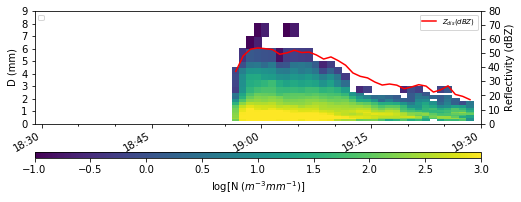

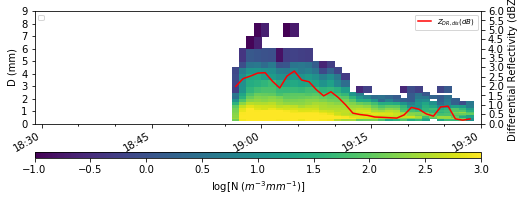

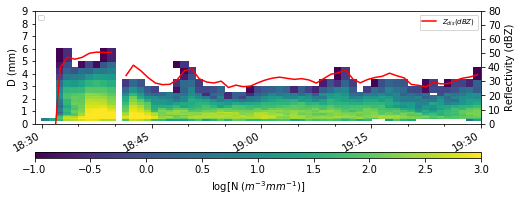

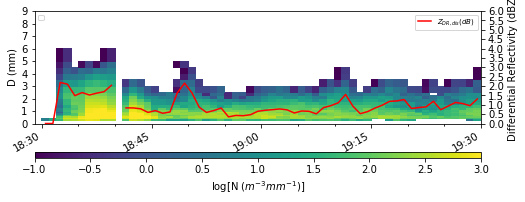

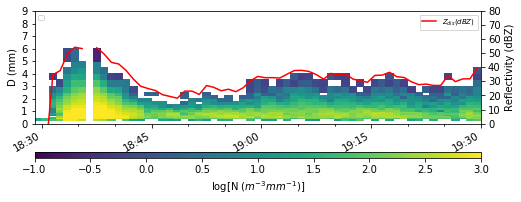

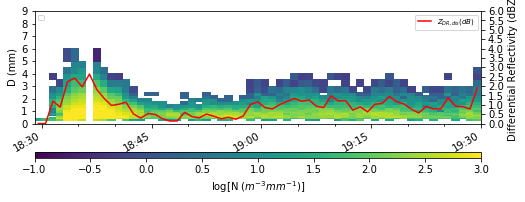

In [5]:
# Plot observed DSD meteograms interpolated to model times
# Get PSD times valid at the model times

PSD_datetimes_model = pips.get_PSD_datetimes(PIPS_ARPS_ds_list[0], dim_name='time')
PSD_datetimes_model_dict = pips.get_PSD_time_bins(PSD_datetimes_model)
PSDstarttimes = dates.date2num(PSD_datetimes_model_dict['PSD_datetimes_edges'])
PSDmidtimes = dates.date2num(PSD_datetimes_model_dict['PSD_datetimes_centers'])

# Prepare axis parameters
# We'll use the model times for the boundaries of the x-axis
timelimits = [PSDstarttimes[0], PSDstarttimes[-1]]
diamlimits = [0.0, 9.0]
diamytick = 1.0
DSDtype = 'observed'
locator = dates.MinuteLocator(byminute=[0,15,30,45])
minorlocator = dates.MinuteLocator(byminute=range(0,60,5))
dateformat = '%H:%M'
formatter = dates.DateFormatter(dateformat)

axparams = {'majorxlocator': locator, 'majorxformatter': formatter,
            'minorxlocator': minorlocator,
            'axeslimits': [timelimits, diamlimits],
            'majorylocator': ticker.MultipleLocator(base=diamytick),
            'axeslabels': [None, 'D (mm)']}

# Ok, now we should have everything ready to go to plot the meteograms.
# Let'er rip!
for PIPS_ARPS_ds in PIPS_ARPS_ds_list:
    ND = PIPS_ARPS_ds['ND_qc']
    logND = np.log10(ND)
    D0 = dsd.calc_D0_bin(ND) * 1000. # Get to mm
    dualpol_PIPS = pol.calpolrain(wavelength, scatt_file, ND, bin_width)
    dBZ = dualpol_PIPS['REF']
    ZDR = dualpol_PIPS['ZDR']
    
    disvars = {'min_diameter': min_diameters, 'PSDstarttimes': PSDstarttimes,
               'PSDmidtimes': PSDmidtimes, 'logND': logND.T, 'D_0': D0, 'REF': dBZ, 'ZDR': ZDR}
    
    dis_plot_name = PIPS_ARPS_ds.probe_name + '_interp_to_model_' + DSDtype
    PIPSplot.plotDSDmeteograms(dis_plot_name, meteogram_plotdir, axparams, disvars, close_fig=False)

/home/cbelak/.conda/envs/cent7/5.1.0-py27/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:601: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/cbelak/.conda/envs/cent7/5.1.0-py27/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:601: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


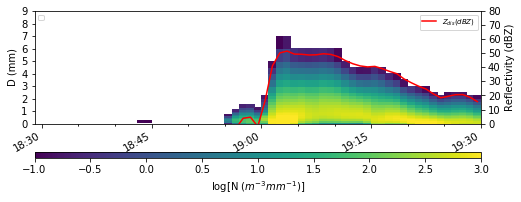

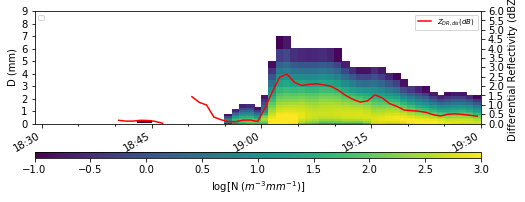

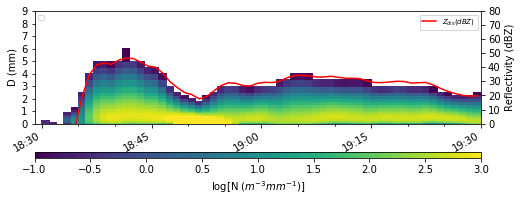

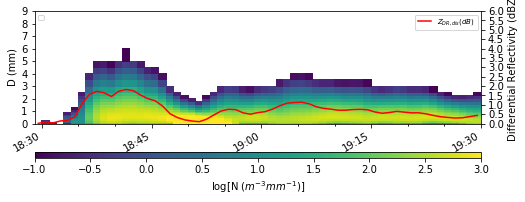

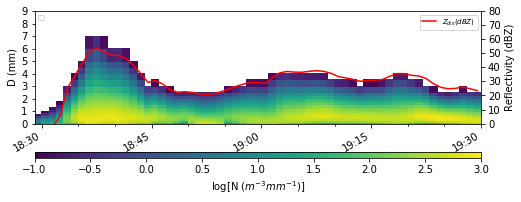

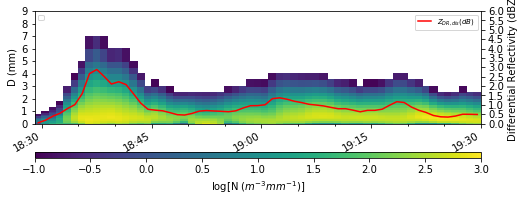

In [6]:
member = 1
for PIPS_ARPS_ds in PIPS_ARPS_ds_list:
    ND_ARPS = PIPS_ARPS_ds['ND'].sel(member=member) / 1000. # Get to m^-3 mm^-1 TODO: really need to make this
                                                            # consistent with PIPS ND...
    logND_ARPS = np.log10(ND_ARPS)
    logND_ARPS = logND_ARPS.where(logND_ARPS >= -1.)
    D0_ARPS = dsd.calc_D0_bin(ND_ARPS) * 1000. # Get to mm
    dualpol_ARPS = pol.calpolrain(wavelength, scatt_file, ND_ARPS, bin_width)
    dBZ = dualpol_ARPS['REF']
    ZDR = dualpol_ARPS['ZDR']
    disvars = {'min_diameter': min_diameters, 'PSDstarttimes': PSDstarttimes,
               'PSDmidtimes': PSDmidtimes, 'logND': logND_ARPS.T, 'D_0': D0_ARPS, 'REF': dBZ, 'ZDR': ZDR}
    
    dis_plot_name = '{}_raw_model_member_{:d}'.format(PIPS_ARPS_ds.probe_name, member)
    PIPSplot.plotDSDmeteograms(dis_plot_name, meteogram_plotdir, axparams, disvars, close_fig=False)

In [7]:
dBZ_combined = {}
    
for PIPS_ARPS_ds in PIPS_ARPS_ds_list:
    dBZ_combined[PIPS_ARPS_ds.probe_name] = []
    for member in range (1,41):
        ND_ARPS = PIPS_ARPS_ds['ND'].sel(member=member) / 1000. # Get to m^-3 mm^-1 TODO: really need to make this
                                                            # consistent with PIPS ND...
        logND_ARPS = np.log10(ND_ARPS)
        logND_ARPS = logND_ARPS.where(logND_ARPS >= -1.)
        D0_ARPS = dsd.calc_D0_bin(ND_ARPS) * 1000. # Get to mm
        dualpol_ARPS = pol.calpolrain(wavelength, scatt_file, ND_ARPS, bin_width)
        dBZ = dualpol_ARPS['REF']
        ZDR = dualpol_ARPS['ZDR']
        disvars = {'min_diameter': min_diameters, 'PSDstarttimes': PSDstarttimes,
                   'PSDmidtimes': PSDmidtimes, 'logND': logND_ARPS.T, 'D_0': D0_ARPS, 'REF': dBZ, 'ZDR': ZDR}
        dBZ_combined[PIPS_ARPS_ds.probe_name].append(dBZ)
    dBZ_combined[PIPS_ARPS_ds.probe_name] = np.array(dBZ_combined[PIPS_ARPS_ds.probe_name]).reshape(40*61)
print(dBZ_combined)
    
#   dis_plot_name = '{}_raw_model_member_{:d}'.format(PIPS_ARPS_ds.probe_name, member)
#    PIPSplot.plotDSDmeteograms(dis_plot_name, meteogram_plotdir, axparams, disvars, close_fig=False)

/home/cbelak/.conda/envs/cent7/5.1.0-py27/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:601: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/cbelak/.conda/envs/cent7/5.1.0-py27/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:601: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/cbelak/.conda/envs/cent7/5.1.0-py27/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:601: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/cbelak/.conda/envs/cent7/5.1.0-py27/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:601: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/cbelak/.conda/envs/cent7/5.1.0-py27/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:601: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/cbelak/.conda/envs/

/home/cbelak/.conda/envs/cent7/5.1.0-py27/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:601: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/cbelak/.conda/envs/cent7/5.1.0-py27/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:601: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/cbelak/.conda/envs/cent7/5.1.0-py27/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:601: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/cbelak/.conda/envs/cent7/5.1.0-py27/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:601: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/cbelak/.conda/envs/cent7/5.1.0-py27/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:601: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/cbelak/.conda/envs/

/home/cbelak/.conda/envs/cent7/5.1.0-py27/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:601: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


{'PIPS2B': array([       -inf,        -inf,        -inf, ..., 19.0375453 ,
       19.09365589, 16.47963948]), 'PIPS1A': array([-51.49755567, -44.49774855, -49.70810284, ...,  20.52869651,
        20.36309741,  21.11016999]), 'PIPS1B': array([-20.33058617, -10.76495503,  -2.28023275, ...,  22.50038996,
        19.82711903,  18.73861332])}


In [46]:
# Create a combined DataArray for all the ensemble members and then convert to a DataFrame for use in seaborn
PIPS_time_range = {
    'PIPS1A': [datetime(2017, 4, 30, 18, 30), datetime(2017, 4, 30, 19, 30)],
    'PIPS1B': [datetime(2017, 4, 30, 18, 30), datetime(2017, 4, 30, 19, 30)],
    'PIPS2B': [datetime(2017, 4, 30, 18, 30), datetime(2017, 4, 30, 19, 30)]
}

PIPS_names = [PIPS_ARPS_ds.probe_name for PIPS_ARPS_ds in PIPS_ARPS_ds_list]
PIPS_to_plot = 'PIPS2B'
PIPS_to_plot_index = PIPS_names.index(PIPS_to_plot)

# D0_raw_model_list = []
# for PIPS_ARPS_ds in PIPS_ARPS_ds_list:
#     D0_raw_model_list.append(dsd.calc_D0_bin(PIPS_ARPS_ds['ND']) * 1000.)
# D0_raw_model_combined = xr.concat(D0_raw_model_list, xr.DataArray(PIPS_names, dims='PIPS'))
# print(D0_raw_model_combined)
ND = PIPS_ARPS_ds_list[PIPS_to_plot_index]['ND']
D0_raw_model_combined = dsd.calc_D0_bin(ND) * 1000.
D0_raw_model_combined_df = D0_raw_model_combined.to_dataframe(name='D0')
print(D0_raw_model_combined_df)

D0_raw_model_combined_df["DBZ"] = dBZ_combined[PIPS_to_plot]
print(D0_raw_model_combined_df)

# # D0
# D0_raw_model_list = [D0_raw_model_dict[PIPS_to_plot].reset_coords(drop=True) 
#                             for D0_raw_model_dict in D0_raw_model_dict_list]
# D0_raw_model_combined = xr.concat(D0_raw_model_list, dim='member')
# D0_raw_model_combined_df = D0_raw_model_combined.to_dataframe(name='D0')


# # Reflectivity

# dBZ_raw_model_list = [dBZ_raw_model_dict[PIPS_to_plot].reset_coords(drop=True) 
#                             for dBZ_raw_model_dict in dBZ_raw_model_dict_list]
# dBZ_raw_model_combined = xr.concat(dBZ_raw_model_list, dim='member')
# dBZ_raw_model_combined_df = dBZ_raw_model_combined.to_dataframe(name='dBZ')

# # ZDR

# ZDR_raw_model_list = [dualpol_raw_model_dict[PIPS_to_plot]['ZDR'].reset_coords(drop=True) 
#                             for dualpol_raw_model_dict in dualpol_raw_model_dict_list]
# ZDR_raw_model_combined = xr.concat(ZDR_raw_model_list, dim='member')
# ZDR_raw_model_combined_df = ZDR_raw_model_combined.to_dataframe(name='ZDR')

                                     xc            yc           xe  \
member time                                                          
1      2017-04-30 18:30:00  99462.97991  84331.502037  99462.97991   
       2017-04-30 18:31:00  99462.97991  84331.502037  99462.97991   
       2017-04-30 18:32:00  99462.97991  84331.502037  99462.97991   
       2017-04-30 18:33:00  99462.97991  84331.502037  99462.97991   
       2017-04-30 18:34:00  99462.97991  84331.502037  99462.97991   
...                                 ...           ...          ...   
40     2017-04-30 19:26:00  99462.97991  84331.502037  99462.97991   
       2017-04-30 19:27:00  99462.97991  84331.502037  99462.97991   
       2017-04-30 19:28:00  99462.97991  84331.502037  99462.97991   
       2017-04-30 19:29:00  99462.97991  84331.502037  99462.97991   
       2017-04-30 19:30:00  99462.97991  84331.502037  99462.97991   

                                      ye    PIPS        D0  
member time                 

/home/cbelak/.conda/envs/cent7/5.1.0-py27/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:601: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/cbelak/.conda/envs/cent7/5.1.0-py27/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:601: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


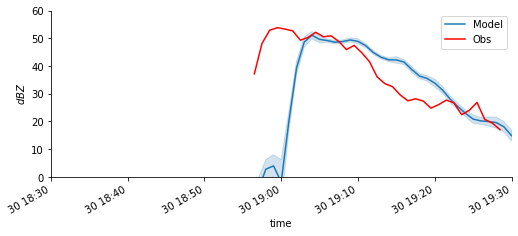

In [47]:
# Plot a timeseries of D0 with confidence intervals from the model ensemble
import seaborn as sns

#PSD_datetimes_model = pips.get_PSD_datetimes(var_ds, dim_name='time')
#PSD_datetimes_model_dict = pips.get_PSD_time_bins(PSD_datetimes_model)
#PSDstarttimes = dates.date2num(PSD_datetimes_model_dict['PSD_datetimes_edges'])
#PSDmidtimes = dates.date2num(PSD_datetimes_model_dict['PSD_datetimes_centers'])

ND = PIPS_ARPS_ds_list[PIPS_to_plot_index]['ND_qc']
logND = np.log10(ND)
D0 = dsd.calc_D0_bin(ND) * 1000. # Get to mm
dualpol_PIPS = pol.calpolrain(wavelength, scatt_file, ND, bin_width)
dBZ_obs = dualpol_PIPS['REF']
dBZ_obs_df = dBZ_obs.to_dataframe(name='dBZ_obs')

    
ND = PIPS_ARPS_ds_list[PIPS_to_plot_index]['ND_qc']
D0_obs = dsd.calc_D0_bin(ND) * 1000. # Get to mm
D0_raw_model_combined_df_test = D0_raw_model_combined_df.copy()
D0_raw_model_combined_df_test.reset_index(inplace=True)
g = sns.relplot(x="time", y="DBZ", kind="line", ci="sd", data=D0_raw_model_combined_df_test, label='Model')
g.fig.set_size_inches(8., 3., forward = True)
g.fig.autofmt_xdate()
g.set_ylabels(r'$dBZ$')
g.ax.plot(PSDmidtimes, dBZ_obs, 'r', label='Obs')
plt.legend(loc='best')
g.ax.set_xlim(PIPS_time_range[PIPS_to_plot])
g.ax.set_ylim(0,60)

figname = '{}_model_obs_dBZ_original.png'.format(PIPS_to_plot)
figpath = os.path.join(meteogram_plotdir, figname)
plt.savefig(figpath, dpi=300, bbox_inches='tight')

In [48]:
# D0_raw_model_combined_df_test['D0']
# D0_obs
cc_combined = []
bias_combined = []
abs_bias_combined = []

for member in range(1,40+1):
    member -= 1
#     print(D0_raw_model_combined_df_test['D0'][0+61*member:61+61*member])
#     print(D0_obs)
    cc = pd.DataFrame({'mod':D0_raw_model_combined_df_test['DBZ'][0+61*member:61+61*member],'obs':dBZ_obs}).corr().iloc[0,1]
#     print(cc)
    bias = np.nansum(D0_raw_model_combined_df_test['DBZ'][0+61*member:61+61*member]-dBZ_obs) / dBZ_obs.isnull().count()
#     print(D0_obs.isnull().count())
#     print(bias)
    abs_bias = np.nansum(abs(D0_raw_model_combined_df_test['DBZ'][0+61*member:61+61*member]-dBZ_obs)) / dBZ_obs.isnull().count()

    bias_combined.append(bias)
    abs_bias_combined.append(abs_bias)
    cc_combined.append(cc)
bias_avg=np.mean(bias_combined)
abs_bias_avg=np.mean(abs_bias_combined)
cc_avg=np.mean(cc_combined)
print(bias_avg)
print(cc_avg)
print(abs_bias_avg)

    #pd.set_option('mode.use_inf_as_na', True)




/home/cbelak/.conda/envs/cent7/5.1.0-py27/pyPIPS/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


nan
0.2352138897590515
inf


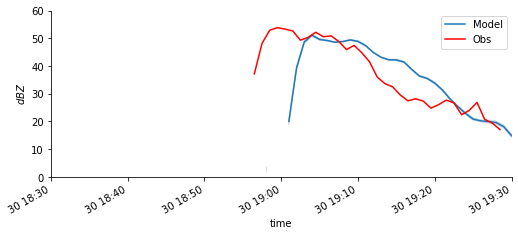

In [23]:
# Plot a timeseries of D0 with confidence intervals from the model ensemble
import seaborn as sns

#PSD_datetimes_model = pips.get_PSD_datetimes(var_ds, dim_name='time')
#PSD_datetimes_model_dict = pips.get_PSD_time_bins(PSD_datetimes_model)
#PSDstarttimes = dates.date2num(PSD_datetimes_model_dict['PSD_datetimes_edges'])
#PSDmidtimes = dates.date2num(PSD_datetimes_model_dict['PSD_datetimes_centers'])

ND = PIPS_ARPS_ds_list[PIPS_to_plot_index]['ND_qc']
D0_obs = dsd.calc_D0_bin(ND) * 1000. # Get to mm
D0_raw_model_combined_df_test = D0_raw_model_combined_df.copy()
D0_raw_model_combined_df_test.reset_index(inplace=True)
g = sns.relplot(x="time", y="DBZ", kind="line", ci=95, data=D0_raw_model_combined_df_test, label='Model')
g.fig.set_size_inches(8., 3., forward = True)
g.fig.autofmt_xdate()
g.set_ylabels(r'$dBZ$')
g.ax.plot(PSDmidtimes, dBZ_obs, 'r', label='Obs')
plt.legend(loc='best')
g.ax.set_xlim(PIPS_time_range[PIPS_to_plot])
g.ax.set_ylim(0,60)

figname = '{}_model_obs_dBZ_new.png'.format(PIPS_to_plot)
figpath = os.path.join(meteogram_plotdir, figname)
plt.savefig(figpath, dpi=300, bbox_inches='tight')

/home/cbelak/.conda/envs/cent7/5.1.0-py27/pyPIPS/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1291: RuntimeWarning: invalid value encountered in double_scalars
  stats['iqr'] = q3 - q1
/home/cbelak/.conda/envs/cent7/5.1.0-py27/pyPIPS/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/home/cbelak/.conda/envs/cent7/5.1.0-py27/pyPIPS/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/home/cbelak/.conda/envs/cent7/5.1.0-py27/pyPIPS/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1291: RuntimeWarning: invalid value encountered in double_scalars
  stats['iqr'] = q3 - q1
/home/cbelak/.conda/envs/cent7/5.1.0-py27/pyPIPS/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/home/cbelak/.conda/envs

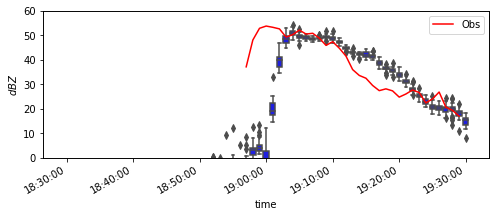

In [24]:
# Plot a timeseries of D0 with confidence intervals from the model ensemble
import seaborn as sns

#PSD_datetimes_model = pips.get_PSD_datetimes(var_ds, dim_name='time')
#PSD_datetimes_model_dict = pips.get_PSD_time_bins(PSD_datetimes_model)
#PSDstarttimes = dates.date2num(PSD_datetimes_model_dict['PSD_datetimes_edges'])
#PSDmidtimes = dates.date2num(PSD_datetimes_model_dict['PSD_datetimes_centers'])

#ND = PIPS_ARPS_ds_list[PIPS_to_plot_index]['ND_qc']
#D0_obs = dsd.calc_D0_bin(ND) * 1000. # Get to mm
#D0_obs_df = D0_obs.to_dataframe(name='D0_obs')
#D0_raw_model_combined_df_test = D0_raw_model_combined_df.copy()
#D0_raw_model_combined_df_test.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(8,3))
# Create a new axes object "ax2" that is a twin of ax
ax2 = ax.twinx()
#g = sns.boxplot(x="time", y="D0",data=D0_raw_model_combined_df_test, ax=ax)
#g.fig.set_size_inches(8., 3., forward = True)
ax.set_ylabel(r'$dBZ$')
#D0_obs_df.reset_index(inplace=True)
#sns.lineplot(x="time", y="D0", data=D0_raw_model_combined_df_test, label='Model', ax=ax)
#sns.lineplot(x="time", y="D0_obs", data=D0_obs_df, label='Obs', ax=ax)
sns.boxplot(x="time", y="DBZ",data=D0_raw_model_combined_df_test, ax=ax, color='blue')
# Plot the observation line plot on ax2 instead of ax, and give it a simple range of indices
# from 0 to the length of the D0_obs_df Dataframe, that is, the number of times.
ax2.plot(np.arange(len(dBZ_obs_df)), dBZ_obs_df['dBZ_obs'].values, label='Obs', color='red')
plt.legend(loc='best')

# Code snippet from https://stackoverflow.com/questions/53528054/
# the-most-elegant-way-to-modify-messy-and-overlapping-date-labels-below-x-axis

# set the frequency for labelling the xaxis
freq = int(10)
# set the xlabels as the datetime data for the given labelling frequency,
# also use only the date for the label
ax.set_xticklabels(D0_raw_model_combined_df_test.iloc[::freq].time.dt.time)
# set the xticks at the same frequency as the xlabels
xtix = ax.get_xticks()
ax.set_xticks(xtix[::freq])
# nicer label format for dates
fig.autofmt_xdate()

# Set the two axes to have the same y-range. Very important!
ax.set_ylim(0., 60.0)
ax2.set_ylim(0., 60.0)

ax.set_ylabel(r'$dBZ$')
# Turns of the y ticks and labels for the right side of the graph that would otherwise be placed there
plt.tick_params(axis='y', which='both', right=False, labelright=False)

figname = '{}_model_obs_dBZ_box_new_2.png'.format(PIPS_to_plot)
figpath = os.path.join(meteogram_plotdir, figname)
plt.savefig(figpath, dpi=300, bbox_inches='tight')

In [25]:
#print(D0_raw_model_combined_df_test)
#D0_obs_pydatetime = D0_obs_df.set_index('time').index.to_pydatetime()
#print(D0_obs_pydatetime)
#print(PSDmidtimes)

/home/cbelak/.conda/envs/cent7/5.1.0-py27/pyPIPS/lib/python3.7/site-packages/matplotlib/colors.py:972: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/cbelak/.conda/envs/cent7/5.1.0-py27/pyPIPS/lib/python3.7/site-packages/matplotlib/colors.py:973: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/home/cbelak/.conda/envs/cent7/5.1.0-py27/pyPIPS/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


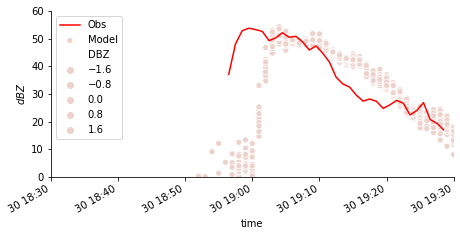

In [26]:
# Plot a timeseries of D0 with confidence intervals from the model ensemble
import seaborn as sns
import matplotlib.colors 
from matplotlib.colors import LogNorm

#PSD_datetimes_model = pips.get_PSD_datetimes(var_ds, dim_name='time')
#PSD_datetimes_model_dict = pips.get_PSD_time_bins(PSD_datetimes_model)
#PSDstarttimes = dates.date2num(PSD_datetimes_model_dict['PSD_datetimes_edges'])
#PSDmidtimes = dates.date2num(PSD_datetimes_model_dict['PSD_datetimes_centers'])

#ND = PIPS_ARPS_ds_list[PIPS_to_plot_index]['ND_qc']
#D0_obs = dsd.calc_D0_bin(ND) * 1000. # Get to mm
#D0_obs_df = D0_obs.to_dataframe(name='D0_obs')
#D0_raw_model_combined_df_test = D0_raw_model_combined_df.copy()
#D0_raw_model_combined_df_test.reset_index(inplace=True)

palette = sns.cubehelix_palette(light=0.7,n_colors=6)
g = sns.relplot(x="time", y="DBZ", hue="DBZ",data=D0_raw_model_combined_df_test, label="Model")

#g.ax.plot(time, D0, 'b', kind="line", data=D0_raw_model_combined_df_test, label="Model")

g.fig.set_size_inches(8., 3., forward = True)
g.fig.autofmt_xdate()
g.set_ylabels(r'$dBZ$')
g.ax.plot(PSDmidtimes, dBZ_obs, 'r', label='Obs')
plt.legend(loc='best')
g.ax.set_xlim(PIPS_time_range[PIPS_to_plot])
g._legend.remove()
g.ax.set_ylim(0,60)

figname = '{}_model_obs_dBZ_color.png'.format(PIPS_to_plot)
figpath = os.path.join(meteogram_plotdir, figname)
plt.savefig(figpath, dpi=300, bbox_inches='tight')


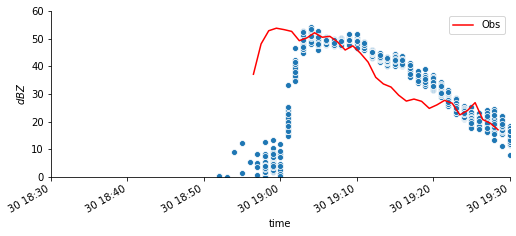

In [27]:
# Plot a timeseries of D0 with confidence intervals from the model ensemble
import seaborn as sns
import matplotlib.colors 
from matplotlib.colors import LogNorm

#PSD_datetimes_model = pips.get_PSD_datetimes(var_ds, dim_name='time')
#PSD_datetimes_model_dict = pips.get_PSD_time_bins(PSD_datetimes_model)
#PSDstarttimes = dates.date2num(PSD_datetimes_model_dict['PSD_datetimes_edges'])
#PSDmidtimes = dates.date2num(PSD_datetimes_model_dict['PSD_datetimes_centers'])

#ND = PIPS_ARPS_ds_list[PIPS_to_plot_index]['ND_qc']
#D0_obs = dsd.calc_D0_bin(ND) * 1000. # Get to mm
#D0_raw_model_combined_df_test = D0_raw_model_combined_df.copy()
#D0_raw_model_combined_df_test.reset_index(inplace=True)

palette = sns.cubehelix_palette(light=0.7,n_colors=6)
g = sns.relplot(x="time", y="DBZ",data=D0_raw_model_combined_df_test)

#g.ax.plot(time, D0, 'b', kind="line", data=D0_raw_model_combined_df_test, label="Model")

g.fig.set_size_inches(8., 3., forward = True)
g.fig.autofmt_xdate()
g.set_ylabels(r'$dBZ$')
g.ax.plot(PSDmidtimes, dBZ_obs, 'r', label='Obs')
plt.legend(loc='best')
g.ax.set_xlim(PIPS_time_range[PIPS_to_plot])
g.ax.set_ylim(0,60)

#g._legend.remove()

figname = '{}_model_obs_dBZ_spread.png'.format(PIPS_to_plot)
figpath = os.path.join(meteogram_plotdir, figname)
plt.savefig(figpath, dpi=300, bbox_inches='tight')


In [ ]:
# ZDR
ZDR_obs = dualpol_PIPS_interp_to_model_times_dict[PIPS_to_plot]['ZDR']
ZDR_raw_model_combined_df_test = ZDR_raw_model_combined_df.copy()
ZDR_raw_modehttp://localhost:8888/notebooks/ARPS_PIPS_comp_stats_new_CCN_1000_original.ipynb#l_combined_df_test.reset_index(inplace=True)
g = sns.relplot(x="time", y="ZDR", kind="line", ci="sd", data=ZDR_raw_model_combined_df_test, label='Model')
g.fig.set_size_inches(8., 3., forward = True)
g.fig.autofmt_xdate()
g.set_ylabels(r'$Z_{DR}$ (dB)')
g.ax.plot(PSDmidtimes, ZDR_obs, 'r', label='Obs')
plt.legend(loc='best')
g.ax.set_xlim(PIPS_time_range[PIPS_to_plot])

figname = '{}_model_obs_ZDR.png'.format(PIPS_to_plot)
figpath = os.path.join(meteogram_plotdir, figname)
plt.savefig(figpath, dpi=300, bbox_inches='tight')

In [ ]:
# Now plot the raw model DSDs (interpolated to PIPS locations but not the times)

PSDstarttimes = dates.date2num(PSD_datetimes_model_dict['PSD_datetimes_edges'])
PSDmidtimes = dates.date2num(PSD_datetimes_model_dict['PSD_datetimes_centers'])

for member, logND_model_raw_PIPS_dict in enumerate(logND_model_raw_PIPS_dict_list):
    for i, dis_name in enumerate(dis_names):
        logND = logND_model_raw_PIPS_dict[dis_name]
        logND = logND.where(logND > -1.0)
        D0 = D0_raw_model_dict[dis_name] * 1000. # Get to mm again
        dBZ = dBZ_raw_model_dict[dis_name]
        ZDR = dualpol_raw_model_dict[dis_name]['ZDR']
        disvars = {'min_diameter': min_diameters, 'PSDstarttimes': PSDstarttimes,
                   'PSDmidtimes': PSDmidtimes, 'logND': logND.T, 'D_0': D0, 'dBZ': dBZ, 'ZDR': ZDR}
        dis_plot_name = dis_name + '_raw_model_member_{:02d}_'.format(member+1) + DSDtype
        PIPSplot.plotDSDmeteograms(dis_plot_name, meteogram_plotdir, axparams, disvars, close_fig=False)

In [ ]:
# Now plot the mean raw model DSDs (interpolated to PIPS locations but not the times)

PSDstarttimes = dates.date2num(PSD_datetimes_model_dict['PSD_datetimes_edges'])
PSDmidtimes = dates.date2num(PSD_datetimes_model_dict['PSD_datetimes_centers'])

for i, dis_name in enumerate(dis_names):
    logND_all = logND_model_raw_combined_da.isel(PIPS=i)
    logND_mean = logND_all.mean(dim='member')
    logND_mean = logND_mean.where(logND_mean > -1.0)
#     D0 = D0_raw_model_dict[dis_name] * 1000. # Get to mm again
#     dBZ = dBZ_raw_model_dict[dis_name]
#     ZDR = dualpol_raw_model_dict[dis_name]['ZDR']
#     disvars = {'min_diameter': min_diameters, 'PSDstarttimes': PSDstarttimes,
#                'PSDmidtimes': PSDmidtimes, 'logND': logND.T, 'D_0': D0, 'dBZ': dBZ, 'ZDR': ZDR}
    disvars = {'min_diameter': min_diameters, 'PSDstarttimes': PSDstarttimes,
               'PSDmidtimes': PSDmidtimes, 'logND': logND_mean.T}
    dis_plot_name = dis_name + '_raw_model_member_mean_' + DSDtype
    PIPSplot.plotDSDmeteograms(dis_plot_name, meteogram_plotdir, axparams, disvars, close_fig=False)

In [ ]:
# Now compute sampled PSDs from the model
DSDtype = 'observed'
# Now plot the sampled model DSD

sampling_interval = 60.
sampling_length = pp.parsivel_parameters['sensor_length_mm'] / 1000. # To m
sampling_width = pp.parsivel_parameters['sensor_width_mm'] / 1000. # To m

Dmax = 9.
Dmax_index = np.searchsorted(mid_diameters, Dmax, side='right')
# print(Dmax_index)
mid_diameters_trunc = np.array(mid_diameters[:Dmax_index+1]) / 1000.
min_diameters_trunc = np.array(min_diameters[:Dmax_index+1]) / 1000.
max_diameters_trunc = np.array(max_diameters[:Dmax_index+1]) / 1000.

PSDstarttimes = dates.date2num(PSD_datetimes_model_dict['PSD_datetimes_edges'])
PSDmidtimes = dates.date2num(PSD_datetimes_model_dict['PSD_datetimes_centers'])

D0_sample_dict_list = []
ND_sample_dict_list = []
dBZ_sample_dict_list = []
dualpol_sample_dict_list = []

for member, var_ds_interp in enumerate(var_ds_interp_list):

    D0_sample_dict = {}
    ND_sample_dict = {}
    dBZ_sample_dict = {}
    dualpol_sample_dict = {}

    for dis_name in dis_names:
        nr_model = var_ds_interp['nr'].loc[dict(PIPS=dis_name)].values
        lamdar_model = var_ds_interp['lamdar'].loc[dict(PIPS=dis_name)].values
        alphar_model = var_ds_interp['alphar'].loc[dict(PIPS=dis_name)].values
        rho_model = var_ds_interp['rho'].loc[dict(PIPS=dis_name)].values

        # print(mid_diameters_trunc.shape)
        Vtr = pips.calc_empirical_fallspeed(mid_diameters_trunc * 1000., correct_rho=True, rho=rho_model)

        Vtr = Vtr.T
    #     print(Vtr[0])
    #     print(Vtr.shape)
    #     print(mid_diameters_trunc.shape)
        ND_samp_series = np.zeros((np.size(PSDmidtimes), np.size(mid_diameters_trunc)))

    #     print(ND_samp_series.shape)
    #     print(nr_model[0])
        # Nc_bin_tmp2 = np.zeros((np.size(N0r), np.size(D[:Dmax_index+1])))
        # Nc_bin2 = np.zeros((np.size(np.array(sampling_times)), np.size(D[:Dmax_index+1])))

        all_valid = (not np.isnan(lamdar_model[0]) and (not np.isnan(alphar_model[0])) and (not np.isnan(nr_model[0])))
        if all_valid:
            # Special treatment for first sampling time. Just assume DSD valid at that time was constant for the previous 
            # sampling interval
            sample_dict = sim.create_random_gamma_DSD(nr_model[0], lamdar_model[0], 
                                                      alphar_model[0], Vtr[0], sampling_length, 
                                                      sampling_width, min_diameters_trunc, mid_diameters_trunc, 
                                                      max_diameters_trunc, Dmax=Dmax, sampling_interval=sampling_interval,
                                                      remove_margins=True, rhocorrect=True, rho=rho_model[0], verbose=False)


            ND_sample = sample_dict['ND']
            pcount_binned_sample = sample_dict['pcount_binned']
        #     print(ND_sample.shape)
        #     print(ND_samp_series.shape)
            ND_samp_series[0, :] = 1.e-3*ND_sample
            # Nc_bin_tmp2[0, :] = 1.e-3*ND_sample
            # Nc_bin2[0, :] = Nc_bin_tmp2[0, :]


        pcount_binned_samples = []
        for index in range(np.size(PSDmidtimes[1:])):
            all_valid = (not np.isnan(lamdar_model[index]) 
                         and (not np.isnan(alphar_model[index]))
                         and (not np.isnan(nr_model[index])))
            # print('nr = ', nr_model[index], 'lamdar = ', lamdar_model[index], 'alphar = ', alphar_model[index])
            if all_valid:
                sample_dict = sim.create_random_gamma_DSD(nr_model[index], lamdar_model[index], 
                                                          alphar_model[index], Vtr[index], sampling_length, 
                                                          sampling_width, min_diameters_trunc, mid_diameters_trunc, 
                                                          max_diameters_trunc, Dmax=Dmax, sampling_interval=sampling_interval,
                                                          remove_margins=True, rhocorrect=True, rho=rho_model[index], verbose=False)
                ND_sample = sample_dict['ND']
                pcount_binned_samples.append(sample_dict['pcount_binned'])
                ND_samp_series[index, :] = 1.e-3*ND_sample
            else:
                pcount_binned_samples.append(np.zeros(np.size(mid_diameters_trunc)+1))
                #pcount_binned_samples.append(np.zeros_like(sample_dict['pcount_binned']))

        pcount_binned_samples = np.array(pcount_binned_samples)

        ND_samp_da = xr.DataArray(ND_samp_series,
                                         coords={'time': PSD_datetimes_model_dict['PSD_datetimes_edges'][:-1],
                                                 'diameter': ('diameter_bin', mid_diameters_trunc * 1000.),
                                                 'max_diameter': ('diameter_bin', max_diameters_trunc * 1000.),
                                                 'min_diameter': ('diameter_bin', min_diameters_trunc * 1000.)
                                                },
                                         dims=['time', 'diameter_bin'])

        ND_samp_da = ND_samp_da.fillna(0.0)

        # sampling_volumes_D = sim.calc_sampling_volumes_D(Vtr, Dr, Dmax, sampling_interval, sampling_area)
        # for s, sample_index in enumerate(sample_indices[:-1]):
        #     sample_index_end = sample_indices[s+1]
        #     current_sample_indices = slice(sample_index, sample_index_end, None)
        #     pcount_binned = np.sum(pcount_binned_samples[current_sample_indices], axis=0)
        #     Nc_bin2[s+1, :] = 1.e-3*sim.calc_ND(pcount_binned, sampling_volumes_D, Dr, Dl, Dmax)
        # #     Nc_bin2[s+1, :] = np.sum(Nc_bin_tmp2[current_sample_indices, :]*dt[current_sample_indices, None], axis = 0)/sampling_interval
        # #     print "s = ", s
        # #     print "sample time (beginning) = ", sampling_times[s]
        # #     print "sample time (end) = ", sampling_times[s+1]
        # #     print "dt[current_sample_indices] = ", dt[current_sample_indices]
        # #     print "Nc_bin_tmp = ", Nc_bin_tmp[current_sample_indices, :], dt[current_sample_indices]
        # #     print "Nc_bin = ", Nc_bin[s+1, :]

        logND_samp_da = np.log10(ND_samp_da)
        logND_samp_da = logND_samp_da.where(logND_samp_da > -1.0)

        # Compute dBZ and D0 from the sampled DSD
        dBZ_samp_model = dsd.calc_dBZ_from_bins(ND_samp_da)
        dBZ_samp_model = dBZ_samp_model.where(dBZ_samp_model > -np.inf)
        D0_samp_model = dsd.calc_D0_bin(ND_samp_da) * 1000. # Get to mm again
        pol_samp_model_dict = pol.calpolrain(wavelength, scatt_file, ND_samp_da, bin_width)

        dBZ_sample_dict[dis_name] = dBZ_samp_model
        D0_sample_dict[dis_name] = D0_samp_model
        dualpol_sample_dict[dis_name] = pol_samp_model_dict
        ND_sample_dict[dis_name] = ND_samp_da

        disvars = {'min_diameter': min_diameters[:Dmax_index+1], 'PSDstarttimes': PSDstarttimes,
                   'PSDmidtimes': PSDmidtimes, 'logND': logND_samp_da.T, 'D_0': D0_samp_model, 
                   'dBZ': dBZ_samp_model, 'ZDR': pol_samp_model_dict['ZDR']}
        dis_plot_name = dis_name + '_sampled_model_member_{:02d}_'.format(member+1) + DSDtype
        PIPSplot.plotDSDmeteograms(dis_plot_name, meteogram_plotdir, axparams, disvars, close_fig=True)
    
    D0_sample_dict_list.append(D0_sample_dict)
    ND_sample_dict_list.append(ND_sample_dict)
    dBZ_sample_dict_list.append(dBZ_sample_dict)
    dualpol_sample_dict_list.append(dualpol_sample_dict)
    

In [ ]:
# Let's make some statistical comparison plots

# Make some one-to-one plots of D0 (model) vs. D0 (disdrometer)

yvals = pp.parsivel_parameters['avg_diameter_bins_mm']
xvals = yvals

color_list = ['r', 'orange', 'g', 'b']

fig_all, ax_all = plt.subplots(figsize=(8,8))

for d, dis_name in enumerate(dis_names):
    obs = D0_PIPS_interp_to_model_times_dict[dis_name] * 1000.
    mod = D0_raw_model_dict[dis_name] * 1000.
    mod_sampled = D0_sample_dict[dis_name]
    bias_mod = ((np.nansum(mod - obs)) / np.nansum(obs))
    bias_mod_sampled = ((np.nansum(mod_sampled - obs)) / np.nansum(obs))
    cc_mod = pd.DataFrame({'obs': obs, 'mod': mod}).corr().iloc[0, 1]
    cc_mod_sampled = pd.DataFrame({'obs': obs, 'mod': mod_sampled}).corr().iloc[0, 1]
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.scatter(obs, mod, c=color_list[d], marker='*', label=dis_name+'_gamma')
    plt.scatter(obs, mod_sampled, c=color_list[d], marker='+', alpha=0.75, label=dis_name+'_sampled')
    ax_all.scatter(obs, mod, c=color_list[d], marker='*', label=dis_name+'_gamma')
    ax_all.scatter(obs, mod_sampled, c=color_list[d], marker='+', alpha=0.75, label=dis_name+'_sampled')
    ax.plot(xvals, yvals, lw=2, color='k')
    ax.set_xlim(0.0, 6.0)
    ax.set_ylim(0.0, 6.0)
    ax.set_xlabel('Observed')
    ax.set_ylabel('Model')
    ax.text(0.6, 0.20, 'Bias (model): {:2.2f}'.format(bias_mod), transform=ax.transAxes)
    ax.text(0.6, 0.15, 'Cor. Coef. (model) {:2.3f}'.format(cc_mod), transform=ax.transAxes)
    ax.text(0.6, 0.10, 'Bias (model sampled): {:2.2f}'.format(bias_mod_sampled), transform=ax.transAxes)
    ax.text(0.6, 0.05, 'Cor. Coef. (model sampled) {:2.3f}'.format(cc_mod_sampled), transform=ax.transAxes)
    plt.legend(loc='upper left')

D0_raw_model_list = [v for k, v in D0_raw_model_dict.items()]
D0_PIPS_list = [v for k, v in D0_PIPS_interp_to_model_times_dict.items()]
D0_samp_model_list = [v for k, v in D0_sample_dict.items()]

D0r_mod = xr.concat(D0_raw_model_list, dim='PIPS') * 1000.
D0r_obs = xr.concat(D0_PIPS_list, dim='PIPS') * 1000.  
D0r_mod_samp = xr.concat(D0_samp_model_list, dim='PIPS')

bias_mod_all = ((np.nansum(D0r_mod - D0r_obs)) / np.nansum(D0r_obs))
bias_mod_samp_all = ((np.nansum(D0r_mod_samp - D0r_obs)) / np.nansum(D0r_obs))
cc_mod_all = pd.DataFrame({'obs': D0r_obs.stack(points=['PIPS', 'time']), 
                           'mod': D0r_mod.stack(points=['PIPS', 'time'])}).corr().iloc[0, 1]
cc_mod_samp_all = pd.DataFrame({'obs': D0r_obs.stack(points=['PIPS', 'time']),
                                'mod': D0r_mod_samp.stack(points=['PIPS', 'time'])}).corr().iloc[0, 1]

ax_all.plot(xvals, yvals, lw=2, color='k')
ax_all.set_xlim(0.0, 6.0)
ax_all.set_ylim(0.0, 6.0)
ax_all.set_xlabel('Observed')
ax_all.set_ylabel('Model')
ax_all.text(0.6, 0.20, 'Bias (model): {:2.2f}'.format(bias_mod_all), transform=ax_all.transAxes)
ax_all.text(0.6, 0.15, 'Cor. Coef. (model) {:2.3f}'.format(cc_mod_all), transform=ax_all.transAxes)
ax_all.text(0.6, 0.10, 'Bias (model sampled): {:2.2f}'.format(bias_mod_samp_all), transform=ax_all.transAxes)
ax_all.text(0.6, 0.05, 'Cor. Coef. (model sampled) {:2.3f}'.format(cc_mod_samp_all), transform=ax_all.transAxes)
plt.legend(loc='upper left')

In [ ]:
# Let's make some statistical comparison plots

# Make some one-to-one plots of ZDR (model) vs. ZDR (disdrometer)

yvals = pp.parsivel_parameters['avg_diameter_bins_mm']
xvals = yvals

color_list = ['r', 'orange', 'g', 'b']

fig_all, ax_all = plt.subplots(figsize=(8,8))

for d, dis_name in enumerate(dis_names):
    obs = dualpol_PIPS_interp_to_model_times_dict[dis_name]['ZDR']
    mod = dualpol_raw_model_dict[dis_name]['ZDR']
    mod_sampled = dualpol_sample_dict[dis_name]['ZDR']
    bias_mod = ((np.nansum(mod - obs)) / np.nansum(obs))
    bias_mod_sampled = ((np.nansum(mod_sampled - obs)) / np.nansum(obs))
    cc_mod = pd.DataFrame({'obs': obs, 'mod': mod}).corr().iloc[0, 1]
    cc_mod_sampled = pd.DataFrame({'obs': obs, 'mod': mod_sampled}).corr().iloc[0, 1]
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.scatter(obs, mod, c=color_list[d], marker='*', label=dis_name+'_gamma')
    plt.scatter(obs, mod_sampled, c=color_list[d], marker='+', alpha=0.75, label=dis_name+'_sampled')
    ax_all.scatter(obs, mod, c=color_list[d], marker='*', label=dis_name+'_gamma')
    ax_all.scatter(obs, mod_sampled, c=color_list[d], marker='+', alpha=0.75, label=dis_name+'_sampled')
    ax.plot(xvals, yvals, lw=2, color='k')
    ax.set_xlim(0.0, 6.0)
    ax.set_ylim(0.0, 6.0)
    ax.set_xlabel('Observed')
    ax.set_ylabel('Model')
    ax.text(0.6, 0.20, 'Bias (model): {:2.2f}'.format(bias_mod), transform=ax.transAxes)
    ax.text(0.6, 0.15, 'Cor. Coef. (model) {:2.3f}'.format(cc_mod), transform=ax.transAxes)
    ax.text(0.6, 0.10, 'Bias (model sampled): {:2.2f}'.format(bias_mod_sampled), transform=ax.transAxes)
    ax.text(0.6, 0.05, 'Cor. Coef. (model sampled) {:2.3f}'.format(cc_mod_sampled), transform=ax.transAxes)
    plt.legend(loc='upper left')

ZDR_raw_model_list = [v['ZDR'] for k, v in dualpol_raw_model_dict.items()]
ZDR_PIPS_list = [v['ZDR'] for k, v in dualpol_PIPS_interp_to_model_times_dict.items()]
ZDR_samp_model_list = [v['ZDR'] for k, v in dualpol_sample_dict.items()]

ZDR_mod = xr.concat(ZDR_raw_model_list, dim='PIPS')
ZDR_obs = xr.concat(ZDR_PIPS_list, dim='PIPS') 
ZDR_mod_samp = xr.concat(ZDR_samp_model_list, dim='PIPS')

bias_mod_all = ((np.nansum(ZDR_mod - ZDR_obs)) / np.nansum(ZDR_obs))
bias_mod_samp_all = ((np.nansum(ZDR_mod_samp - ZDR_obs)) / np.nansum(ZDR_obs))
cc_mod_all = pd.DataFrame({'obs': ZDR_obs.stack(points=['PIPS', 'time']), 
                           'mod': ZDR_mod.stack(points=['PIPS', 'time'])}).corr().iloc[0, 1]
cc_mod_samp_all = pd.DataFrame({'obs': ZDR_obs.stack(points=['PIPS', 'time']),
                                'mod': ZDR_mod_samp.stack(points=['PIPS', 'time'])}).corr().iloc[0, 1]

ax_all.plot(xvals, yvals, lw=2, color='k')
ax_all.set_xlim(0.0, 6.0)
ax_all.set_ylim(0.0, 6.0)
ax_all.set_xlabel('Observed')
ax_all.set_ylabel('Model')
ax_all.text(0.6, 0.20, 'Bias (model): {:2.2f}'.format(bias_mod_all), transform=ax_all.transAxes)
ax_all.text(0.6, 0.15, 'Cor. Coef. (model) {:2.3f}'.format(cc_mod_all), transform=ax_all.transAxes)
ax_all.text(0.6, 0.10, 'Bias (model sampled): {:2.2f}'.format(bias_mod_samp_all), transform=ax_all.transAxes)
ax_all.text(0.6, 0.05, 'Cor. Coef. (model sampled) {:2.3f}'.format(cc_mod_samp_all), transform=ax_all.transAxes)
plt.legend(loc='upper left')

In [ ]:
# Calculate dual-pol variables for both the model and observations and make scatterplots of Z vs. ZDR
# Z, ZDR relation from Cao et al. (2008)
Zh_Cao = np.arange(10, 61, 0.1)
Zdr_Cao = 10**((-2.6857 * 10**-4 * Zh_Cao**2) + 0.04892 * Zh_Cao - 1.4287)
color_list = ['r', 'orange', 'g', 'b']

for d, dis_name in enumerate(dis_names):
    
    
    dualpol_mod = dualpol_sample_dict[dis_name]
    dualpol_mod_raw = dualpol_raw_model_dict[dis_name]
    dualpol_obs = dualpol_PIPS_interp_to_model_times_dict[dis_name]
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    sc = plt.scatter(dualpol_mod['dBZ'], dualpol_mod['ZDR'], c=color_list[d], marker='*', label=dis_name+'_mod',
                     vmin=-15000., vmax=15000.)
    sc = plt.scatter(dualpol_mod_raw['dBZ'], dualpol_mod_raw['ZDR'], c=color_list[d], marker='+', label=dis_name+'_mod_raw',
                     vmin=-15000., vmax=15000.)
    plt.scatter(dualpol_obs['dBZ'], dualpol_obs['ZDR'], c=color_list[d], marker='o', label=dis_name+'_obs', vmin=-15000., vmax=15000.)
    plt.plot(Zh_Cao, Zdr_Cao, c='k', ls='-', lw=1.0)
    #plt.colorbar(sc)
    ax.set_xlabel('dBZ')
    ax.set_ylabel(r'Z$_DR$')
    ax.set_xlim(10.0, 60.0)
    ax.set_ylim(-2.0, 6.0)
    plt.legend(loc='upper left')

In [ ]:
(D0_PIPS_interp_to_model_times_dict['PIPS2B'] * 1000).plot.hist()
(D0_raw_model_dict['PIPS2B'] * 1000.).plot.hist(alpha=0.5)
D0_sample_dict['PIPS2B'].plot.hist(alpha=0.25)

# Old cells below!

In [ ]:
# TODO: maybe it's better to try to do this the other direction: namely interpolate the ND values at the PIPS
# times, which are different for each PIPS, to the common model times.

# Now, interpolate these values at the model times to the PIPS DSD times, one PIPS at a time.
# Also get the PSD time bin edges and centers as a numpy array of python datetime objects
model_vars_PIPS_dict = {}
model_gamma_DSD_params_PIPS_modeltimes_dict = {}
model_gamma_DSD_PIPS_modeltimes_dict = {}
model_gamma_DSD_params_PIPS_dict = {}
model_gamma_DSD_PIPS_dict = {}

# Get PSD times valid at the model times
PSD_datetimes_model = pips.get_PSD_datetimes(var_ds, dim_name='time')
PSD_datetimes_model_dict = pips.get_PSD_time_bins(PSD_datetimes_model)

for dis_name in dis_names:
    
    # Get the DataArrays for individual PIPS
    
    # Velocity-diameter matrix
    vd_matrix_rs_da = vd_matrix_rs_da_dict[dis_name]
    
    # Rename "time" to "time" so that we have the same dimension name as the model
    vd_matrix_rs_da = vd_matrix_rs_da.rename({'time': 'time'})
    
    # Shape, intercept, and slope parameters for model DSD, already interpolated in space to each
    # PIPS location
    # New way
    
    
#     alphar_model_PIPS_da = var_ds_interp['alphar'].loc[dict(PIPS=dis_name)]
#     N0r_model_PIPS_da = var_ds_interp['N0r'].loc[dict(PIPS=dis_name)]
#     lamdar_model_PIPS_da = var_ds_interp['lamdar'].loc[dict(PIPS=dis_name)]
    
    # Do the same for ND and logND
    ND_model_PIPS_da = var_ds_interp['ND'].loc[dict(PIPS=dis_name)]
    logND_model_PIPS_da = var_ds_interp['logND'].loc[dict(PIPS=dis_name)]
    
    # Old way
    alphar_model_PIPS_da = alphar_model_allPIPS_da.loc[dict(PIPS=dis_name)]
    N0r_model_PIPS_da = N0r_model_allPIPS_da.loc[dict(PIPS=dis_name)]
    lamdar_model_PIPS_da = lamdar_model_allPIPS_da.loc[dict(PIPS=dis_name)]
    
    # Get the values of some needed variables from the model dataset, already interpolated in space to each
    # PIPS location
    
    # We just need rho and nr
    rho_model_pips_da = var_ds_interp['rho'].loc[dict(PIPS=dis_name)]
    nr_model_pips_da = var_ds_interp['nr'].loc[dict(PIPS=dis_name)]
    
    # Now interpolate the DSD parameters in time to the PIPS times, which are different for each PIPS
    
    alphar_model_PIPS_da_interp = alphar_model_PIPS_da.interp_like(vd_matrix_rs_da)
    N0r_model_PIPS_da_interp = N0r_model_PIPS_da.interp_like(vd_matrix_rs_da)
    lamdar_model_PIPS_da_interp = lamdar_model_PIPS_da.interp_like(vd_matrix_rs_da)
    
    # Do the same for ND and logND
    ND_model_PIPS_da_interp = ND_model_PIPS_da.interp_like(vd_matrix_rs_da)
    logND_model_PIPS_da_interp = logND_model_PIPS_da.interp_like(vd_matrix_rs_da)
    
    # Do the same for rho and nr
    rho_model_pips_da_interp = rho_model_pips_da.interp_like(vd_matrix_rs_da)
    nr_model_pips_da = nr_model_pips_da.interpolate_na(dim='time')
    nr_model_pips_da_interp = nr_model_pips_da.interp_like(vd_matrix_rs_da)
    
    # Stuff them into a dict of dicts (gahhh!)
    model_gamma_DSD_params_modeltimes_dict = {'alphar': alphar_model_PIPS_da,
                                              'N0r': N0r_model_PIPS_da,
                                              'lamdar': lamdar_model_PIPS_da}
    model_gamma_DSD_params_PIPS_modeltimes_dict[dis_name] = model_gamma_DSD_params_modeltimes_dict
    model_gamma_DSD_params_dict = {'alphar': alphar_model_PIPS_da_interp,
                                   'N0r': N0r_model_PIPS_da_interp,
                                   'lamdar': lamdar_model_PIPS_da_interp}
    model_gamma_DSD_params_PIPS_dict[dis_name] = model_gamma_DSD_params_dict
    
    model_gamma_DSD_modeltimes_dict = {'ND': ND_model_PIPS_da, 
                                       'logND': logND_model_PIPS_da}
    model_gamma_DSD_PIPS_modeltimes_dict[dis_name] = model_gamma_DSD_modeltimes_dict
    
    model_gamma_DSD_dict = {'ND': ND_model_PIPS_da_interp,
                            'logND': logND_model_PIPS_da_interp}
    model_gamma_DSD_PIPS_dict[dis_name] = model_gamma_DSD_dict
    
    model_vars_PIPS_dict[dis_name] = {'rho': rho_model_pips_da_interp, 'nr': nr_model_pips_da_interp}

In [ ]:
# Compute N(D) from the raw model parameters at original model times
import pyPIPS.parsivel_params as pp

ND_model_raw_PIPS_modeltimes_dict = {}
logND_model_raw_PIPS_modeltimes_dict = {}
for i, dis_name in enumerate(dis_names):
    mid_diameters_da = vd_matrix_da_dict[dis_name]['diameter']
    alphar_model_PIPS_da = model_gamma_DSD_params_PIPS_modeltimes_dict[dis_name]['alphar']
    N0r_model_PIPS_da = model_gamma_DSD_params_PIPS_modeltimes_dict[dis_name]['N0r']
    lamdar_model_PIPS_da = model_gamma_DSD_params_PIPS_modeltimes_dict[dis_name]['lamdar']
    print(alphar_model_PIPS_da)
    # Broadcast DSD parameter DataArrays to get everyone on the same dimensional page
    mid_diameters_da, N0r_model_PIPS_da, lamdar_model_PIPS_da, alphar_model_PIPS_da = \
        xr.broadcast(mid_diameters_da, N0r_model_PIPS_da, lamdar_model_PIPS_da, alphar_model_PIPS_da)
    # Transpose these DataArrays to get time as the first dimension
    mid_diameters_da = mid_diameters_da.T
    N0r_model_PIPS_da = N0r_model_PIPS_da.T
    lamdar_model_PIPS_da = lamdar_model_PIPS_da.T
    alphar_model_PIPS_da = alphar_model_PIPS_da.T
    
    ND_model_raw_PIPS = dsd.calc_binned_DSD_from_params(N0r_model_PIPS_da, lamdar_model_PIPS_da, 
                                                        alphar_model_PIPS_da, mid_diameters_da)
    logND_model_raw_PIPS = np.log10(ND_model_raw_PIPS)
    logND_model_raw_PIPS = logND_model_raw_PIPS.where(logND_model_raw_PIPS > -1.0)
    
    ND_model_raw_PIPS_modeltimes_dict[dis_name] = ND_model_raw_PIPS
    logND_model_raw_PIPS_modeltimes_dict[dis_name] = logND_model_raw_PIPS

In [ ]:
# Compute N(D) from the raw model parameters (interpolated to the PIPS times and locations)
import pyPIPS.parsivel_params as pp

ND_model_raw_PIPS_dict = {}
logND_model_raw_PIPS_dict = {}
for i, dis_name in enumerate(dis_names):
    mid_diameters_da = vd_matrix_da_dict[dis_name]['diameter']
    alphar_model_PIPS_da = model_gamma_DSD_params_PIPS_dict[dis_name]['alphar']
    N0r_model_PIPS_da = model_gamma_DSD_params_PIPS_dict[dis_name]['N0r']
    lamdar_model_PIPS_da = model_gamma_DSD_params_PIPS_dict[dis_name]['lamdar']
    # Broadcast DSD parameter DataArrays to get everyone on the same dimensional page
    mid_diameters_da, N0r_model_PIPS_da, lamdar_model_PIPS_da, alphar_model_PIPS_da = \
        xr.broadcast(mid_diameters_da, N0r_model_PIPS_da, lamdar_model_PIPS_da, alphar_model_PIPS_da)
    # Transpose these DataArrays to get time as the first dimension
    mid_diameters_da = mid_diameters_da.T
    N0r_model_PIPS_da = N0r_model_PIPS_da.T
    lamdar_model_PIPS_da = lamdar_model_PIPS_da.T
    alphar_model_PIPS_da = alphar_model_PIPS_da.T
    
    ND_model_raw_PIPS = dsd.calc_binned_DSD_from_params(N0r_model_PIPS_da, lamdar_model_PIPS_da, 
                                                        alphar_model_PIPS_da, mid_diameters_da)
    logND_model_raw_PIPS = np.log10(ND_model_raw_PIPS)
    logND_model_raw_PIPS = logND_model_raw_PIPS.where(logND_model_raw_PIPS > -1.0)
    
    ND_model_raw_PIPS_dict[dis_name] = ND_model_raw_PIPS
    logND_model_raw_PIPS_dict[dis_name] = logND_model_raw_PIPS

In [ ]:
# Compute some radar and DSD parameters from the raw model DSDs (interpolated to PIPS times and locations)
dBZ_raw_model_dict = {}
D0_raw_model_dict = {}
for dis_name in dis_names:
    dBZ_raw_model = dsd.calc_dBZ_from_bins(model_gamma_DSD_PIPS_dict[dis_name]['ND'])
    dBZ_raw_model = dBZ_raw_model.where(dBZ_raw_model > -np.inf)
    dBZ_raw_model_dict[dis_name] = dBZ_raw_model
    D0_raw_model = dsd.calc_D0_bin(model_gamma_DSD_PIPS_dict[dis_name]['ND'])
    D0_raw_model_dict[dis_name] = D0_raw_model

In [ ]:
# # Now plot the raw model DSDs (interpolated to PIPS locations but not the times)

# PSDstarttimes = dates.date2num(PSD_datetimes_model_dict['PSD_datetimes_edges'])
# PSDmidtimes = dates.date2num(PSD_datetimes_model_dict['PSD_datetimes_centers'])

# for i, dis_name in enumerate(dis_names):
#     logND = model_gamma_DSD_PIPS_modeltimes_dict[dis_name]['logND']
#     logND = logND.where(logND > -1.0)
#     disvars = {'min_diameter': min_diameters, 'PSDstarttimes': PSDstarttimes,
#                'PSDmidtimes': PSDmidtimes, 'logND': logND.T}
#     dis_plot_name = dis_name + '_raw_model_modeltimes_' + DSDtype
#     PIPSplot.plotDSDmeteograms(dis_plot_name, plotdir, axparams, disvars)

In [ ]:
# # Now plot the raw model DSDs (interpolated to PIPS locations but not the times) - version 2 with logND computed
# # from interpolated alpha, lamda, N0

# PSDstarttimes = dates.date2num(PSD_datetimes_model_dict['PSD_datetimes_edges'])
# PSDmidtimes = dates.date2num(PSD_datetimes_model_dict['PSD_datetimes_centers'])

# for i, dis_name in enumerate(dis_names):
#     logND = logND_model_raw_PIPS_modeltimes_dict[dis_name]
#     logND = logND.where(logND > -1.0)
#     print(logND)
#     print(PSDstarttimes)
#     disvars = {'min_diameter': min_diameters, 'PSDstarttimes': PSDstarttimes,
#                'PSDmidtimes': PSDmidtimes, 'logND': logND.T}
#     dis_plot_name = dis_name + '_raw_model_modeltimes_v2_' + DSDtype
#     PIPSplot.plotDSDmeteograms(dis_plot_name, plotdir, axparams, disvars)

In [ ]:
# Now plot the raw model DSDs (interpolated to PIPS times and locations)

for i, dis_name in enumerate(dis_names):
    logND = model_gamma_DSD_PIPS_dict[dis_name]['logND']
    logND = logND.where(logND > -1.0)
    D0 = D0_raw_model_dict[dis_name] * 1000. # Get to mm again
    dBZ = dBZ_raw_model_dict[dis_name]
    PSDstarttimes = dates.date2num(PSD_datetimes_rs_PIPS_dict[dis_name]['PSD_datetimes_edges'])
    PSDmidtimes = dates.date2num(PSD_datetimes_rs_PIPS_dict[dis_name]['PSD_datetimes_centers'])
    disvars = {'min_diameter': min_diameters, 'PSDstarttimes': PSDstarttimes,
               'PSDmidtimes': PSDmidtimes, 'logND': logND.T, 'D_0': D0, 'dBZ': dBZ}
    dis_plot_name = dis_name + '_raw_model_{:d}'.format(member) + DSDtype
    PIPSplot.plotDSDmeteograms(dis_plot_name, plotdir, axparams, disvars)

In [ ]:
# # Now plot the raw model DSDs (interpolated to PIPS times and locations) - version 2 with logND computed
# # from interpolated alpha, lamda, N0

# for i, dis_name in enumerate(dis_names):
#     logND = logND_model_raw_PIPS_dict[dis_name]
#     logND = logND.where(logND > -1.0)
#     PSDstarttimes = dates.date2num(PSD_datetimes_rs_PIPS_dict[dis_name]['PSD_datetimes_edges'])
#     PSDmidtimes = dates.date2num(PSD_datetimes_rs_PIPS_dict[dis_name]['PSD_datetimes_centers'])
#     print(logND)
#     print(PSDstarttimes)
#     disvars = {'min_diameter': min_diameters, 'PSDstarttimes': PSDstarttimes,
#                'PSDmidtimes': PSDmidtimes, 'logND': logND.T}
#     dis_plot_name = dis_name + '_raw_model_v2_' + DSDtype
#     PIPSplot.plotDSDmeteograms(dis_plot_name, plotdir, axparams, disvars)

In [ ]:
# Now compute sampled PSDs from the model

# Now plot the sampled model DSD

sampling_interval = 60.
sampling_length = pp.parsivel_parameters['sensor_length_mm'] / 1000. # To m
sampling_width = pp.parsivel_parameters['sensor_width_mm'] / 1000. # To m

Dmax = 9.
Dmax_index = np.searchsorted(mid_diameters, Dmax, side='right')
# print(Dmax_index)
mid_diameters_trunc = np.array(mid_diameters[:Dmax_index+1]) / 1000.
min_diameters_trunc = np.array(min_diameters[:Dmax_index+1]) / 1000.
max_diameters_trunc = np.array(max_diameters[:Dmax_index+1]) / 1000.


for dis_name in dis_names:
    PSDstarttimes = dates.date2num(PSD_datetimes_rs_PIPS_dict[dis_name]['PSD_datetimes_edges'])
    PSDmidtimes = dates.date2num(PSD_datetimes_rs_PIPS_dict[dis_name]['PSD_datetimes_centers'])
    ND_raw = model_gamma_DSD_PIPS_dict[dis_name]['ND']
    # print(ND_raw)
    nr_model = model_vars_PIPS_dict[dis_name]['nr'].values
    lamdar_model = model_gamma_DSD_params_PIPS_dict[dis_name]['lamdar'].values
    alphar_model = model_gamma_DSD_params_PIPS_dict[dis_name]['alphar'].values
    rho_model = model_vars_PIPS_dict[dis_name]['rho'].values

    # print(mid_diameters_trunc.shape)
    Vtr = pips.calc_empirical_fallspeed(mid_diameters_trunc * 1000., correct_rho=True, rho=rho_model)

    Vtr = Vtr.T
#     print(Vtr[0])
#     print(Vtr.shape)
#     print(mid_diameters_trunc.shape)
    ND_samp_series = np.zeros((np.size(PSDmidtimes), np.size(mid_diameters_trunc)))

#     print(ND_samp_series.shape)
#     print(nr_model[0])
    # Nc_bin_tmp2 = np.zeros((np.size(N0r), np.size(D[:Dmax_index+1])))
    # Nc_bin2 = np.zeros((np.size(np.array(sampling_times)), np.size(D[:Dmax_index+1])))

    all_valid = (not np.isnan(lamdar_model[0]) and (not np.isnan(alphar_model[0])) and (not np.isnan(nr_model[0])))
    if all_valid:
        # Special treatment for first sampling time. Just assume DSD valid at that time was constant for the previous 
        # sampling interval
        sample_dict = sim.create_random_gamma_DSD(nr_model[0], lamdar_model[0], 
                                                  alphar_model[0], Vtr[0], sampling_length, 
                                                  sampling_width, min_diameters_trunc, mid_diameters_trunc, 
                                                  max_diameters_trunc, Dmax=Dmax, sampling_interval=sampling_interval,
                                                  remove_margins=True, rhocorrect=True, rho=rho_model[0], verbose=True)


        ND_sample = sample_dict['ND']
        pcount_binned_sample = sample_dict['pcount_binned']
    #     print(ND_sample.shape)
    #     print(ND_samp_series.shape)
        ND_samp_series[0, :] = 1.e-3*ND_sample
        # Nc_bin_tmp2[0, :] = 1.e-3*ND_sample
        # Nc_bin2[0, :] = Nc_bin_tmp2[0, :]

    
    pcount_binned_samples = []
    for index in range(np.size(PSDmidtimes[1:-1])):
        all_valid = (not np.isnan(lamdar_model[index]) 
                     and (not np.isnan(alphar_model[index]))
                     and (not np.isnan(nr_model[index])))
        print('nr = ', nr_model[index], 'lamdar = ', lamdar_model[index], 'alphar = ', alphar_model[index])
        if all_valid:
            sample_dict = sim.create_random_gamma_DSD(nr_model[index], lamdar_model[index], 
                                                      alphar_model[index], Vtr[index], sampling_length, 
                                                      sampling_width, min_diameters_trunc, mid_diameters_trunc, 
                                                      max_diameters_trunc, Dmax=Dmax, sampling_interval=sampling_interval,
                                                      remove_margins=True, rhocorrect=True, rho=rho_model[index], verbose=True)
            ND_sample = sample_dict['ND']
            pcount_binned_samples.append(sample_dict['pcount_binned'])
            ND_samp_series[index, :] = 1.e-3*ND_sample
        else:
            pcount_binned_samples.append(np.zeros_like(sample_dict['pcount_binned']))

    pcount_binned_samples = np.array(pcount_binned_samples)
    
    ND_samp_da = xr.DataArray(ND_samp_series,
                                     coords={'time': PSDmidtimes,
                                             'diameter': ('diameter_bin', mid_diameters_trunc * 1000.),
                                             'max_diameter': ('diameter_bin', max_diameters_trunc * 1000.),
                                             'min_diameter': ('diameter_bin', min_diameters_trunc * 1000.)
                                            },
                                     dims=['time', 'diameter_bin'])
    
    ND_samp_da = ND_samp_da.fillna(0.0)

    # sampling_volumes_D = sim.calc_sampling_volumes_D(Vtr, Dr, Dmax, sampling_interval, sampling_area)
    # for s, sample_index in enumerate(sample_indices[:-1]):
    #     sample_index_end = sample_indices[s+1]
    #     current_sample_indices = slice(sample_index, sample_index_end, None)
    #     pcount_binned = np.sum(pcount_binned_samples[current_sample_indices], axis=0)
    #     Nc_bin2[s+1, :] = 1.e-3*sim.calc_ND(pcount_binned, sampling_volumes_D, Dr, Dl, Dmax)
    # #     Nc_bin2[s+1, :] = np.sum(Nc_bin_tmp2[current_sample_indices, :]*dt[current_sample_indices, None], axis = 0)/sampling_interval
    # #     print "s = ", s
    # #     print "sample time (beginning) = ", sampling_times[s]
    # #     print "sample time (end) = ", sampling_times[s+1]
    # #     print "dt[current_sample_indices] = ", dt[current_sample_indices]
    # #     print "Nc_bin_tmp = ", Nc_bin_tmp[current_sample_indices, :], dt[current_sample_indices]
    # #     print "Nc_bin = ", Nc_bin[s+1, :]

    logND_samp_da = np.log10(ND_samp_da)
    logND_samp_da = logND_samp_da.where(logND_samp_da > -1.0)

    # Compute dBZ and D0 from the sampled DSD
    dBZ_samp_model = dsd.calc_dBZ_from_bins(ND_samp_da)
    dBZ_samp_model = dBZ_samp_model.where(dBZ_samp_model > -np.inf)
    D0_samp_model = dsd.calc_D0_bin(ND_samp_da) * 1000. # Get to mm again
    
    disvars = {'min_diameter': min_diameters[:Dmax_index+1], 'PSDstarttimes': PSDstarttimes,
               'PSDmidtimes': PSDmidtimes, 'logND': logND_samp_da.T, 'D_0': D0_samp_model, 
               'dBZ': dBZ_samp_model}
    dis_plot_name = dis_name + '_sampled_model_{:d}'.format(member) + DSDtype
    PIPSplot.plotDSDmeteograms(dis_plot_name, plotdir, axparams, disvars)

In [ ]:
print(model_vars_PIPS_dict['PIPS1B']['nr'].loc['2016-03-31T22:25':'2016-03-31T22:30'])
print(model_gamma_DSD_params_PIPS_dict['PIPS1B']['lamdar'].loc['2016-03-31T22:25':'2016-03-31T22:30'])
print(model_gamma_DSD_params_PIPS_dict['PIPS1B']['alphar'].loc['2016-03-31T22:25':'2016-03-31T22:30'])
print(model_gamma_DSD_params_PIPS_modeltimes_dict['PIPS1B']['alphar'].loc['2016-03-31T22:25':'2016-03-31T22:30'])